<a href="https://colab.research.google.com/github/Paul-mwaura/South-Africa-COVID19/blob/main/YouTube_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import re
import nltk          #for removing stopwords
import string
from string import punctuation
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

nltk.download('stopwords')
stop = stopwords.words('english')
nltk.download("punkt")
nltk.download("wordnet")

from wordcloud import WordCloud,STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import linear_model
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [83]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger', 'stopwords'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [84]:
df = pd.read_csv("/content/south_africa_covid_youtube-data.csv")
df.head()

,Id,Title,Views,Likes,Dislikes
0,HD0LD6UOvcQ,COVID cases surge in South Africa after omicro...,14078,151,31
1,BtELl7-zE_w,Omicron symptoms &quot;totally different&quot;...,289339,2549,287
2,4EUVge5_a14,SA COVID-19 | A look at current COVID-19 situa...,46197,130,141
3,OFR4LgTqrSM,Discussion | COVID-19 cases climbing,18726,44,86
4,N9iKM417OPI,Omicron variant fuels spike in South Africa CO...,131891,1094,95


In [85]:
df.shape

(50, 5)

In [86]:
df.isna().sum()

Id          0
Title       0
Views       0
Likes       0
Dislikes    0
dtype: int64

In [87]:
df.duplicated().sum()

0

In [88]:
df.columns = df.columns.str.lower()
df.head(2)

,id,title,views,likes,dislikes
0,HD0LD6UOvcQ,COVID cases surge in South Africa after omicro...,14078,151,31
1,BtELl7-zE_w,Omicron symptoms &quot;totally different&quot;...,289339,2549,287


## General Descriptive Summary

In [89]:
count = df['title'].str.split().str.len()
count.index =count.index.astype(str)+ ' words:'
count.sort_index(inplace=True)

In [90]:
print('Total number of words:', count.sum(), 'words')

Total number of words: 571 words


In [91]:
print('Mean number of words per text:',round(count.mean(),2), 'words')

Mean number of words per text: 11.42 words


In [92]:
df['title_length'] =df['title'].str.len()
print('Total length of the dataset:',df['title_length'].sum(), 'words')

Total length of the dataset: 3580 words


In [93]:
print('Mean length of a tweet is:',round(df.title_length.mean(),0), 'characters')
df = df.drop('title_length',axis=1)

Mean length of a tweet is: 72.0 characters


In [94]:
# NORMALIZATION - converts all titles into lowercase
df['tidy_title'] = df['title'].str.lower().apply(str)

## Text Preprocessing

In [95]:
SPECIAL_TOKENS = {
    'quoted': 'quoted_item',
    'non-ascii': 'non_ascii_word',
    'undefined': 'something'
}

def cleaning(text, stem_words=True):    
    def pad_str(s):
        return ' '+s+' '
    
    if pd.isnull(text):
        return ''

    stops = set(stopwords.words("english"))
    # Clean the text, with the option to stem words.
    
    # Empty question
    
    if type(text) != str or text=='':
        return ''

    # Clean the text
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub("[%s]" % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub("\w*\d\w*", "", text)


    text = re.sub("\'s", " ", text) 
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "can not", text)
    text = re.sub("n't", " not ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    
    # remove comma between numbers, i.e. 15,000 -> 15000
    
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    
    ## all numbers should separate from words, this is too aggressive
    
    def pad_number(pattern):
        matched_string = pattern.group(0)
        return pad_str(matched_string)
    text = re.sub('[0-9]+', pad_number, text)
    
    # add padding to punctuations and special chars, we still need them later
    
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    text = re.sub('amp', "", text)
    
    def pad_pattern(pattern):
       matched_string = pattern.group(0)
       return pad_str(matched_string)
    text = re.sub('[\!\?\@\^\+\*\/\,\~\|\`\=\:\;\.\#\\\]', pad_pattern, text) 
        
    text = re.sub('[^\x00-\x7F]+', pad_str(SPECIAL_TOKENS['non-ascii']), text) # replace non-ascii word with special word
    
    
    text = [c for c in text if c not in string.punctuation]
    text = [c for c in text if c != '\n'] # Removing newline
    text = ''.join(text)
    text = text.split('https')[0] # Remove links
    
    # replace the float numbers with a random number, it will be parsed as number afterward, and also been replaced with word "number"
    
    text = re.sub('[0-9]+\.[0-9]+', " 87 ", text)
    
    text = re.sub("[^a-zA-Z]",  # Search for all non-letters
                          " ",          # Replace all non-letters with spaces
                          str(text))
    
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation]).lower()
       # Return a list of words
    return text

In [96]:
df['clean_title'] = df['tidy_title'].apply(cleaning)
df.head()

,id,title,views,likes,dislikes,tidy_title,clean_title
0,HD0LD6UOvcQ,COVID cases surge in South Africa after omicro...,14078,151,31,covid cases surge in south africa after omicro...,covid cases surge in south africa after omicro...
1,BtELl7-zE_w,Omicron symptoms &quot;totally different&quot;...,289339,2549,287,omicron symptoms &quot;totally different&quot;...,omicron symptoms quottotally differentquot fro...
2,4EUVge5_a14,SA COVID-19 | A look at current COVID-19 situa...,46197,130,141,sa covid-19 | a look at current covid-19 situa...,sa a look at current situation in south afr...
3,OFR4LgTqrSM,Discussion | COVID-19 cases climbing,18726,44,86,discussion | covid-19 cases climbing,discussion cases climbing
4,N9iKM417OPI,Omicron variant fuels spike in South Africa CO...,131891,1094,95,omicron variant fuels spike in south africa co...,omicron variant fuels spike in south africa co...


In [97]:
def nonasciiword (text):
  text = re.sub("nonasciiword","",text)

  return text

df['clean_title'] = df['clean_title'].apply(nonasciiword)
df.head(3)

,id,title,views,likes,dislikes,tidy_title,clean_title
0,HD0LD6UOvcQ,COVID cases surge in South Africa after omicro...,14078,151,31,covid cases surge in south africa after omicro...,covid cases surge in south africa after omicro...
1,BtELl7-zE_w,Omicron symptoms &quot;totally different&quot;...,289339,2549,287,omicron symptoms &quot;totally different&quot;...,omicron symptoms quottotally differentquot fro...
2,4EUVge5_a14,SA COVID-19 | A look at current COVID-19 situa...,46197,130,141,sa covid-19 | a look at current covid-19 situa...,sa a look at current situation in south afr...


In [98]:
df.columns

Index(['id', 'title', 'views', 'likes', 'dislikes', 'tidy_title',
       'clean_title'],
      dtype='object')

In [99]:
# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
df['clean_title'] = df['clean_title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df = df[['id', 'clean_title', 'views', 'likes', 'dislikes']]
df.head(3)

,id,clean_title,views,likes,dislikes
0,HD0LD6UOvcQ,covid cases surge south africa omicron discove...,14078,151,31
1,BtELl7-zE_w,omicron symptoms quottotally differentquot del...,289339,2549,287
2,4EUVge5_a14,sa look current situation south africa prof mo...,46197,130,141


## Exploratory Data Analysis

In [101]:
%%capture
!pip install sweetviz
# importing sweetviz
import sweetviz as sv

In [102]:
#to analyze the data and create a report, simply call analyze() method passing in the dataframe as argument
report = sv.analyze(df)

#display the report as html
report.show_html('tweets.html')

                                             |          | [  0%]   00:00 -> (? left)

Report tweets.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### Word Cloud

In [103]:
# Create a word cloud
def cloud(data,backgroundcolor = 'white', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (12, 8))
    plt.imshow(wordcloud)
    plt.axis("off")
    
    plt.show

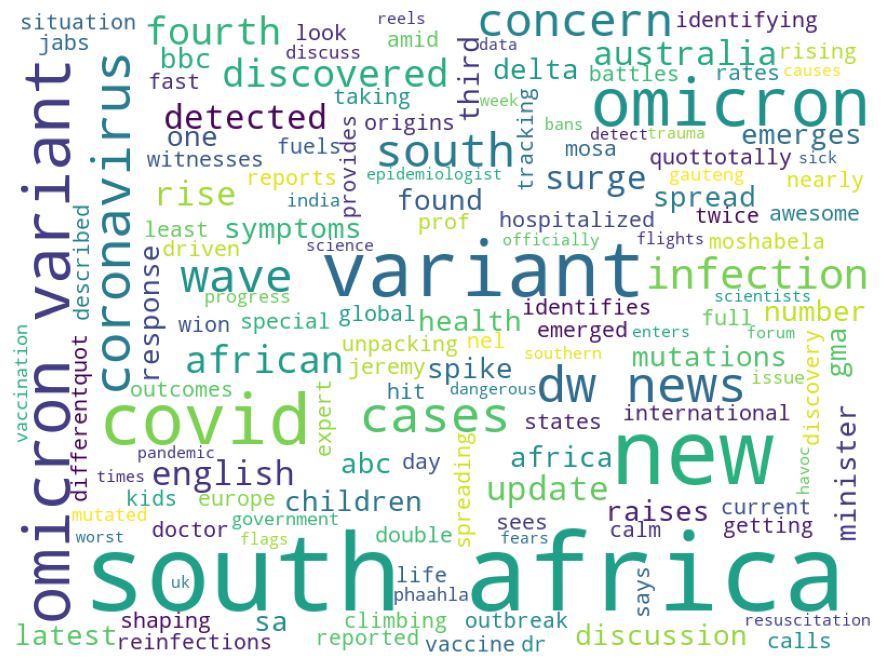

In [105]:
# display the word cloud.
cloud(' '.join(df['clean_title']))

In [108]:
# Get Word Value Counts.
from collections import Counter
df['text_list'] = df['clean_title'].apply(lambda x:str(x).split())
top = Counter([item for sublist in df['text_list'] for item in sublist]) # Counts the frequency of words.
temp = pd.DataFrame(top.most_common(20)) # DataFrame of top 20
temp.columns = ["common_words", "count"]
temp.style.background_gradient(cmap="Blues")

,common_words,count
0,south,43
1,africa,39
2,variant,30
3,omicron,25
4,news,19
5,covid,15
6,new,13
7,coronavirus,8
8,cases,7
9,dw,7


In [109]:
df.to_csv("SA-youtube_covid-data.csv")